# <a id='toc1_'></a>[Notebook pretraitement feature extraction faisaibilite](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Notebook pretraitement feature extraction faisaibilite](#toc1_)    
- [Faisabilité classification des images](#toc2_)    
  - [Lecture d'images](#toc2_1_)    
  - [Processing de la col img](#toc2_2_)    
  - [Analyse graphique et similarité](#toc2_3_)    
    - [Functions](#toc2_3_1_)    
      - [T-SNE et affichage 2D](#toc2_3_1_1_)    
      - [T-SNE et affichage 3D](#toc2_3_1_2_)    
    - [Visualisations en fonction du type de feature extraction](#toc2_3_2_)    
      - [SIFT](#toc2_3_2_1_)    
      - [ORB](#toc2_3_2_2_)    
      - [VGG16](#toc2_3_2_3_)    
- [Faisabilité classification texte](#toc3_)    
  - [Initial Preprocessing](#toc3_1_)    
  - [Features extraction](#toc3_2_)    
    - [Fonctions](#toc3_2_1_)    
    - [Algo de vectorisation / Embeddings](#toc3_2_2_)    
      - [CountVectorizer](#toc3_2_2_1_)    
      - [TF/IDF](#toc3_2_2_2_)    
      - [Word2Vec](#toc3_2_2_3_)    
      - [Sentence Transformer](#toc3_2_2_4_)    
  - [Cluster avec Kmeans](#toc3_3_)    
  - [Conclusion](#toc3_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import os
import re
import zipfile
import string

import plotly.express as px
import tensorflow as tf
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import  adjusted_rand_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import cv2


from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
# import tensorflow_hub as hub



import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder


# Téléchargez les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Requis pour WordNet

os.environ["TF_KERAS"] = "1"
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

c:\Users\vuill\OneDrive\Documents\GitHub\OpenClassrooms\Projet 6 - Classifiez automatiquement des biens de consommation\.venv_p6\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vuill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vuill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vuill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vuill\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Num GPUs Available:  0


In [2]:
# Extraction des données



ZIP_PATH = '../data/Dataset+projet+prétraitement+textes+images.zip'
EXTRACT_PATH = '../data'
DATA_FOLDER = os.path.join(EXTRACT_PATH, "FlipKart")

if not os.path.exists(DATA_FOLDER):
    # Ouvrir le fichier zip
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

    print("Fichiers extraits avec succès dans :", EXTRACT_PATH)
else:
    print('Folder existant !')

print(f'Liste des dossier et fichier disponible {os.listdir(DATA_FOLDER)}')



Folder existant !
Liste des dossier et fichier disponible ['flipkart_com-ecommerce_sample_1050.csv', 'Images']


In [3]:
# Importer le dataset
df = pd.read_csv(os.path.join(DATA_FOLDER, "flipkart_com-ecommerce_sample_1050.csv"))

In [ ]:
def create_labels_column(data):
    """Creation de la colonne label based on product_category_tree

    Args:
        data (dataframe)

    Returns:
        [dataframe]: a dataframe with a col who contain the labels
    """
    if "product_category_tree" in data.columns:
        regex_main_cat = r'\["(.*?)\s?>>'
        # Creation de la colonne main_cat
        data["label"] = data["product_category_tree"].apply(
            lambda x: re.search(regex_main_cat, x).group(1)
            if re.search(regex_main_cat, x)
            else "Unknow"
        )

        # Insérer la colonne main_cat juste après product_category_tree
        col_index = data.columns.get_loc("product_category_tree")
        data.insert(col_index + 1, "label", data.pop("label"))

        return data
    
df = create_labels_column(data=df)
print(df['label'])
# Encoder les labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(df['label'])

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: label, Length: 1050, dtype: object


# <a id='toc2_'></a>[Faisabilité classification des images](#toc0_)

## <a id='toc2_1_'></a>[Lecture d'images](#toc0_)

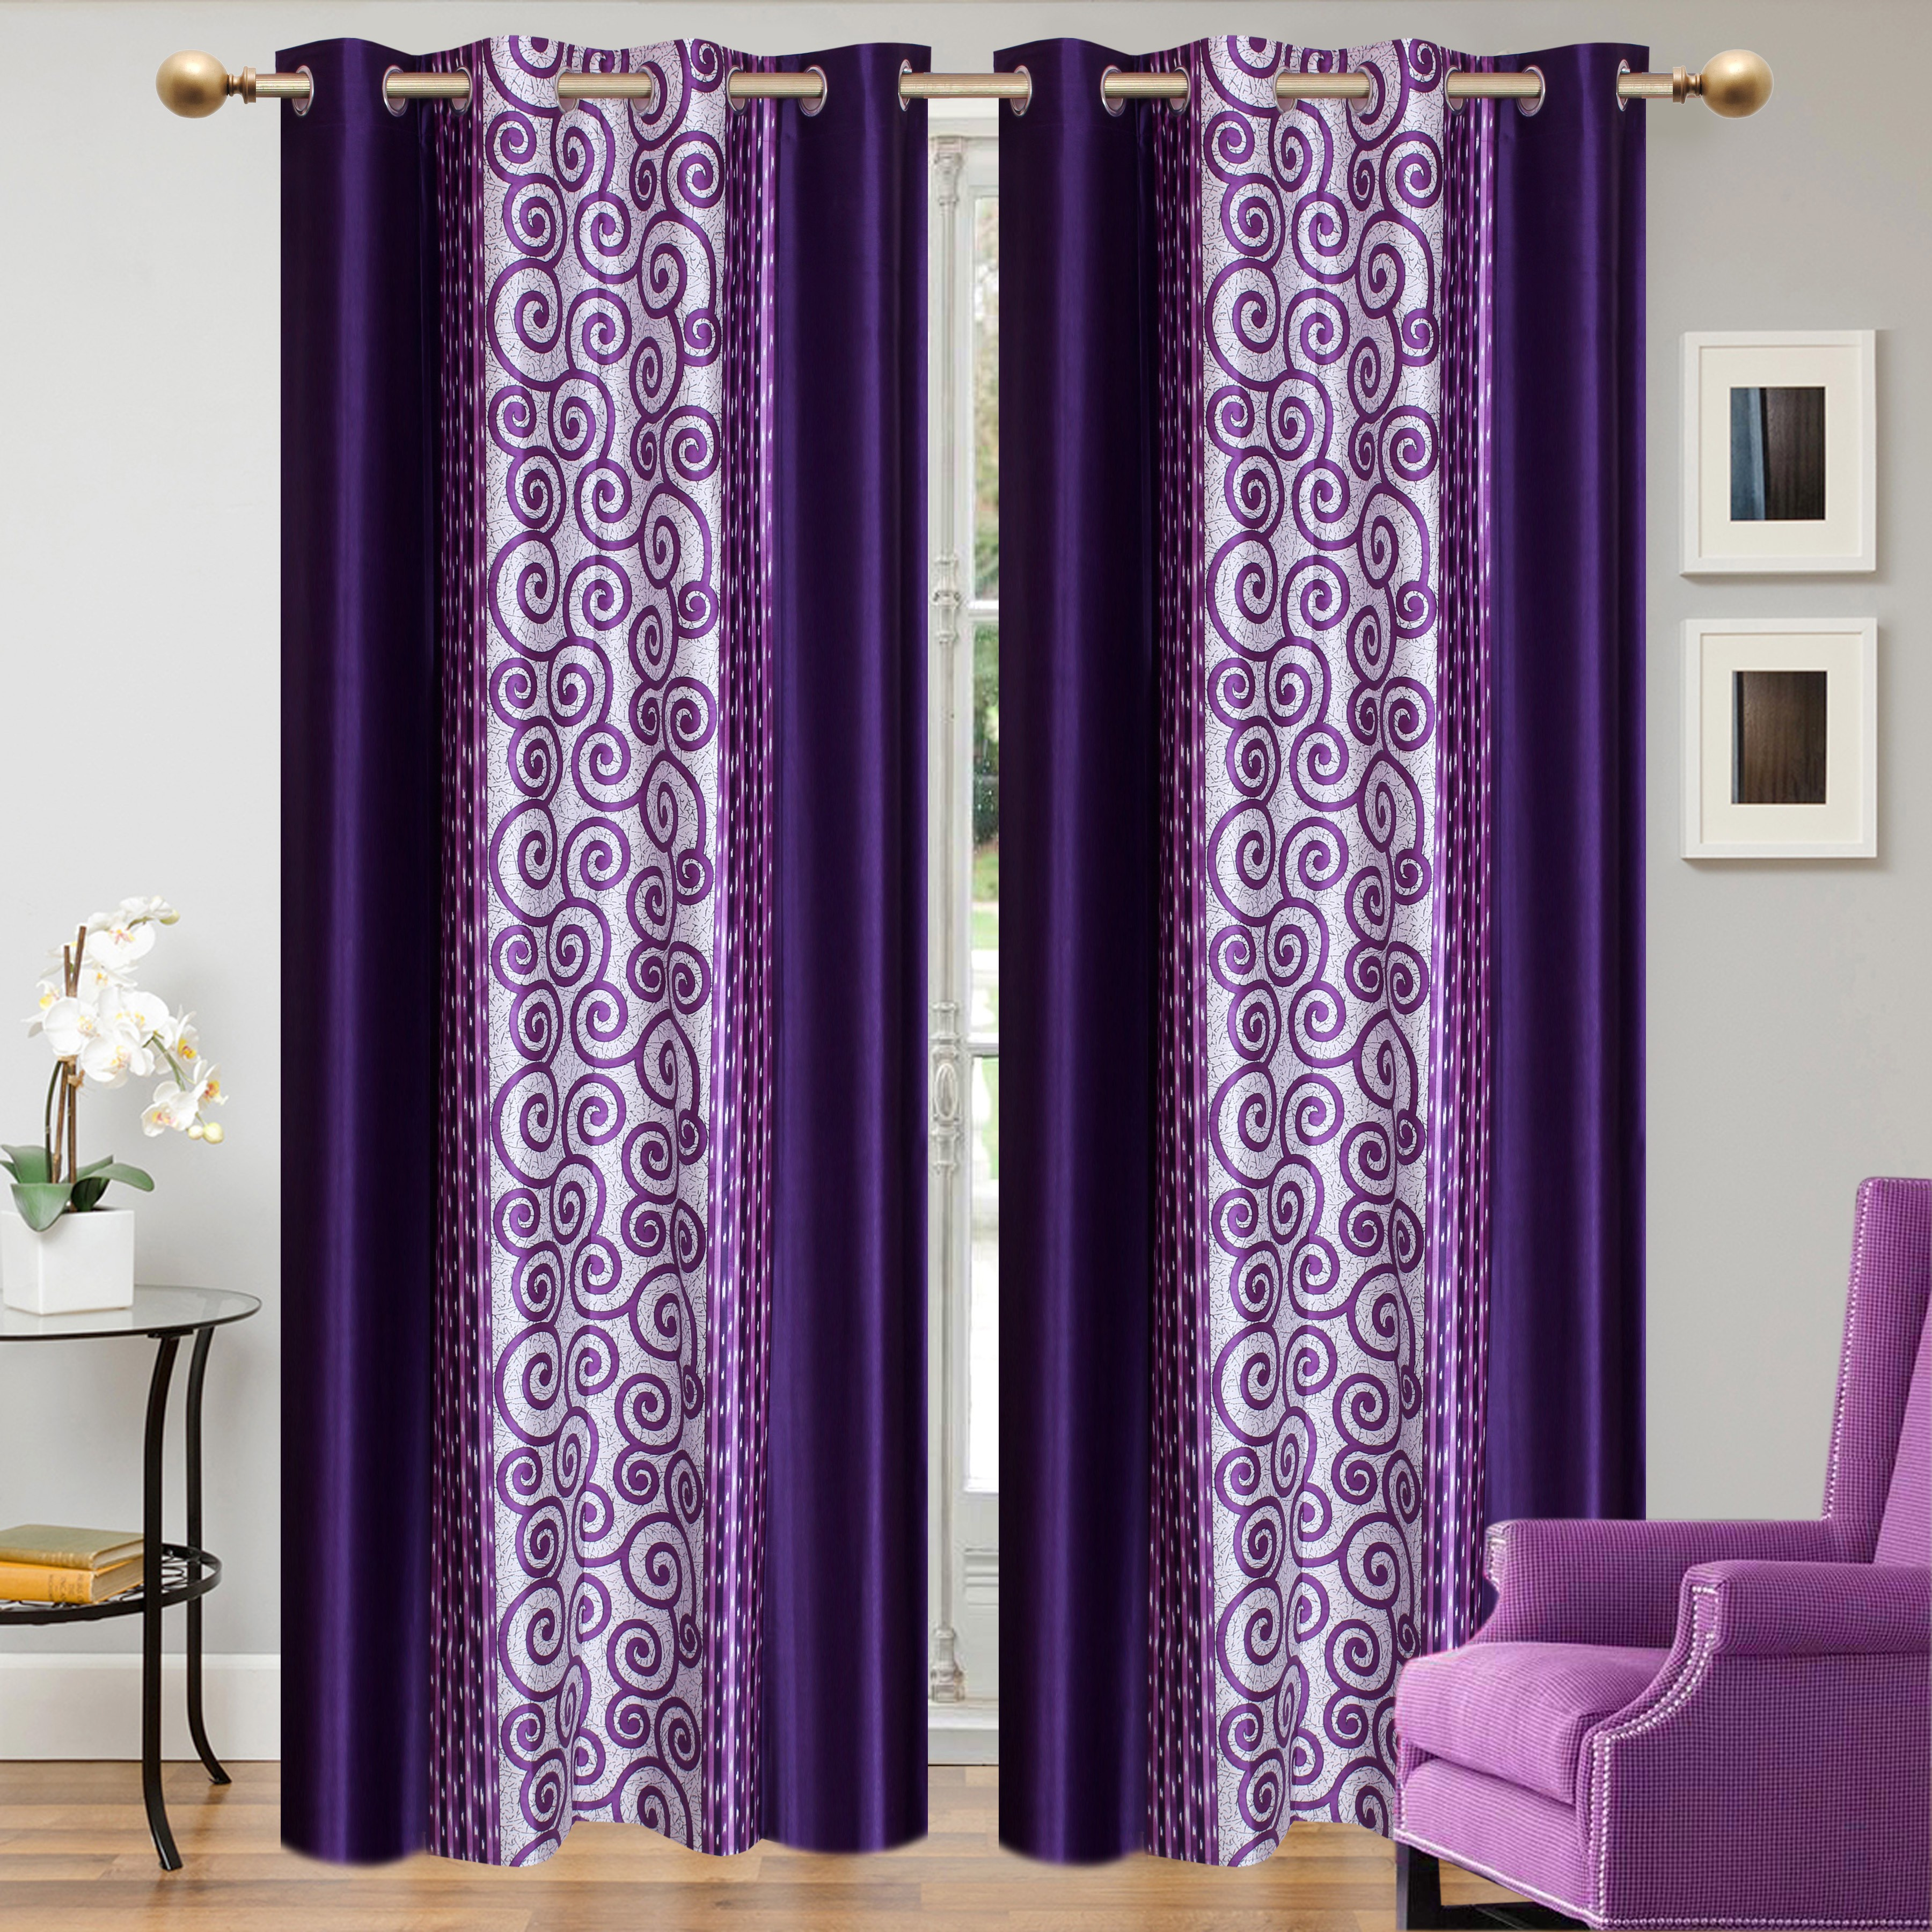

In [23]:
# verifier la correspondance dataset /images
from IPython.display import Image, display

# images path
display(Image(os.path.join(DATA_FOLDER, 'Images', f'{df["image"][0]}')))

In [ ]:
df["product_category_tree"].value_counts()

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                         56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                           26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                  23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                         22
["Home Furnishing >> Bath Linen >> Towels"]                                           19
                                                                                      ..
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Infinity India Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Ravishing Variety Ethnic"]     1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Pg handicrafts Ethnic"]        1
["Home Decor & Festive Needs >> Showpieces >> Ethnic >> Homedesires Ethnic"]           1
["Watches >> Wrist Watches >> Petrol Wrist Watches"]                                   1

## <a id='toc2_2_'></a>[Processing de la col img](#toc0_)

In [25]:
def add_image_path(data, image_col, image_folder):
    """Modification de la colonne image pour avoir le path de l'image a la place

    Args:
        data (dataframe): the current dataframe u use
        image_col (str): the name of the col
        image_folder (str):The path of the folder

    Returns:
        [type]: [description]
    """
    data[image_col] = data[image_col].apply(lambda x: os.path.join(image_folder, x))
    return data

In [26]:
IMAGES_FOLDER_PATH = os.path.join(DATA_FOLDER, "Images")
df = add_image_path(data=df, image_col="image", image_folder=IMAGES_FOLDER_PATH)

In [27]:
df['label'].value_counts()

label
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [ ]:
# Verification du chemin en affichant une image
# display(Image(df["image"][2]))

## <a id='toc2_3_'></a>[Analyse graphique et similarité](#toc0_)

### <a id='toc2_3_1_'></a>[Functions](#toc0_)

#### <a id='toc2_3_1_1_'></a>[T-SNE et affichage 2D](#toc0_)

In [ ]:
def tsne_2d(df,images_features):
    # Paramètres t-SNE
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
    X_tsne = tsne.fit_transform(images_features)

    # Création du DataFrame
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = df["label"]

    # Visualisation
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df_tsne,
        x="tsne1",
        y="tsne2",
        hue="class",
        palette="tab10",
        s=50,
        alpha=0.6
    )
    plt.title("t-SNE selon les vraies classes", fontsize=16)
    plt.xlabel("Dimension 1 (t-SNE)", fontsize=12)
    plt.ylabel("Dimension 2 (t-SNE)", fontsize=12)
    plt.legend(title="Classes")
    plt.show()
    
    return X_tsne

#### <a id='toc2_3_1_2_'></a>[T-SNE et affichage 3D](#toc0_)

In [30]:
def tsne_3d(df, images_features):
    # Paramètres t-SNE
    tsne = manifold.TSNE(n_components=3, perplexity=30, n_iter=2000, init='random', random_state=42)
    X_tsne = tsne.fit_transform(images_features)

    # Création du DataFrame
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2', 'tsne3'])
    df_tsne["class"] = df["label"]

    # Visualisation 3D avec Plotly
    fig = px.scatter_3d(
        df_tsne,
        x='tsne1',
        y='tsne2',
        z='tsne3',
        color='class',  # Couleur basée sur les classes
        title="t-SNE en 3D selon les vraies classes",
        labels={'tsne1': 'Dimension 1 (t-SNE)', 'tsne2': 'Dimension 2 (t-SNE)', 'tsne3': 'Dimension 3 (t-SNE)'},
        color_discrete_sequence=px.colors.qualitative.Plotly,  # Palette de couleurs
        opacity=0.8  # Transparence
    )

    # Personnalisation du layout
    fig.update_layout(
        scene=dict(
            xaxis_title='Dimension 1 (t-SNE)',
            yaxis_title='Dimension 2 (t-SNE)',
            zaxis_title='Dimension 3 (t-SNE)'
        ),
        title_font_size=16,
        legend_title_text='Classes'
    )
    fig.show()
    return X_tsne

In [ ]:
def ari_score(df, images_features):
    model = KMeans(n_clusters=7, n_init=100)
    clusters = model.fit_predict(images_features)

    df['cluster'] = clusters
    true_labels = df['label']

    ari = adjusted_rand_score(true_labels,clusters)
    print('Score ARI: ', ari)
    return ari

### <a id='toc2_3_2_'></a>[Visualisations en fonction du type de feature extraction](#toc0_)

#### <a id='toc2_3_2_1_'></a>[SIFT](#toc0_)
SIFT (Scale-Invariant Feature Transform) est un algorithme de vision par ordinateur utilisé pour détecter et décrire des points d'intérêt ("keypoints") dans une image. Il extrait des caractéristiques locales invariantes aux changements d'échelle, de rotation et de luminosité, permettant une représentation robuste des objets ou scènes.

Source: [Introduction to SIFT( Scale Invariant Feature Transform)](https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40)

In [32]:
sift = cv2.SIFT_create()

def SIFT_feature_extraction(df, max_keypoints=50):
    images_features = []
    
    for image_file in tqdm(df['image'], desc='Extracting SIFT features'):
        
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        
        # Detecter les keyspoints et leurs description
        keypoints, descriptor = sift.detectAndCompute(image, None)
        
        # Si pas de keypoint détecté on ajoute un vecteur de zéros
        if descriptor is None:
            descriptor = np.zeros((max_keypoints, 128))
            
        # Standardiser la taille (si < max keypoint on met des zero pour combler sinon on rcupere que les 50 premeier)
        if len(descriptor) > max_keypoints:
            descriptor = descriptor[:max_keypoints]
        else:
            padding = np.zeros((max_keypoints - len(descriptor), 128 ))
            descriptor = np.vstack((descriptor, padding))
            
        # Flatten le descriptor en un seul vecteur
        descriptor_flat = descriptor.flatten()
        images_features.append(descriptor_flat)
        
    images_features = np.asarray(images_features)
    return images_features

sift_images_features = SIFT_feature_extraction(df)

Extracting SIFT features:  64%|██████▍   | 677/1050 [06:05<03:21,  1.85it/s]


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 1498885248 bytes in function 'cv::OutOfMemoryError'


In [ ]:
sift_Xtsne2d = tsne_2d(df, sift_images_features)
sift_Xtsne3d = tsne_3d(df, sift_images_features)
sift_ari_score = ari_score(df, sift_images_features)

#### <a id='toc2_3_2_2_'></a>[ORB](#toc0_)

ORB (Oriented FAST and Rotated BRIEF) est un algorithme de détection et de description de points d'intérêt ("keypoints") dans une image. Il combine deux composants principaux :

- FAST (Features from Accelerated Segment Test) : Un détecteur de keypoints rapide et efficace qui identifie des points remarquables dans l'image.
- BRIEF (Binary Robust Independent Elementary Features) : Un descripteur compact qui encode les caractéristiques locales sous forme binaire, permettant une représentation légère et rapide à calculer.

Sources: [Introduction to ORB (Oriented FAST and Rotated BRIEF)](https://medium.com/@deepanshut041/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf)

In [ ]:
orb = cv2.ORB_create()

def ORB_feature_extraction(df, max_keypoints=50):
    images_features = []
    
    for image_file in tqdm(df['image'], desc='Extracting ORB features'):
        
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        
        # Detecter les keyspoints et leurs description
        keypoints, descriptor = orb.detectAndCompute(image, None)
        
        # Si pas de keypoint détecté on ajoute un vecteur de zéros
        if descriptor is None:
            descriptor = np.zeros((max_keypoints, 32), dtype=np.uint8)
            
        # Standardiser la taille (si < max keypoint on met des zero pour combler sinon on rcupere que les 50 premeier)
        if len(descriptor) > max_keypoints:
            descriptor = descriptor[:max_keypoints]
        else:
            padding = np.zeros((max_keypoints - len(descriptor), 32 ), dtype=np.uint8)
            descriptor = np.vstack((descriptor, padding))
            
        # Flatten le descriptor en un seul vecteur
        descriptor_flat = descriptor.flatten()
        images_features.append(descriptor_flat)
        
    images_features = np.asarray(images_features)
    return images_features

orb_images_features = ORB_feature_extraction(df)

In [ ]:
orb_Xtsne2d = tsne_2d(df, orb_images_features)
orb_Xtsne3d = tsne_3d(df, orb_images_features)
orb_ari_score = ari_score(df, orb_images_features)

#### <a id='toc2_3_2_3_'></a>[VGG16](#toc0_)
L'avant-dernière couche (layers[-2]) est une couche Dense avec 4096 neurones , qui encode des représentations abstraites des images. Ces représentations sont riches en informations et peuvent être utilisées comme features pour d'autres tâches, comme la classification personnalisée, le clustering, ou même la recherche d'images similaires.
En choisissant layers[-2].output, vous extrayez ces représentations abstraites au lieu des probabilités de classification.

![](https://miro.medium.com/v2/resize:fit:1400/1*NNifzsJ7tD2kAfBXt3AzEg.png)

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

def vgg16_feature_extraction(df):
    images_features = []
    for image_file in tqdm(df["image"], desc='Extracting images Features with VGG16') :
        image = load_img(image_file, target_size=(224, 224))
        image = img_to_array(image) 
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

    images_features = np.asarray(images_features)
    return images_features

vgg16_images_features = vgg16_feature_extraction(df)

In [ ]:
vgg16_Xtsne2d = tsne_2d(df, vgg16_images_features)
vgg16_Xtsne3d = tsne_3d(df, vgg16_images_features)
vgg16_ari_score = ari_score(df, vgg16_images_features)

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

# <a id='toc3_'></a>[Faisabilité classification texte](#toc0_)

In [ ]:
# Importer le dataset
df['description']

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

## <a id='toc3_1_'></a>[Initial Preprocessing](#toc0_)
Les données textuelles doivent être soigneusement prétraitées pour garantir une bonne qualité des données d'entrée

In [ ]:
# Initialisation du lemmatizer et des stopwords
lemmatizer = WordNetLemmatizer()
stopwords_english = set(stopwords.words('english'))  # Utilisez 'french' si vos données sont en français

def initial_preprocessing(df, stopwords=True):
    """
    Prétraite toutes les descriptions d'un DataFrame en appliquant les étapes suivantes :
    1. Mise en minuscules
    2. Suppression de la ponctuation
    3. Tokenization
    4. Suppression des stopwords
    5. Lemmatization
    
    Args:
        df (pd.DataFrame): DataFrame contenant une colonne 'description'.
    
    Returns:
        list: Une liste de listes de tokens prétraités.
    """
    preprocessed_descriptions = []  # Pour stocker les résultats
    
    for description in df['description']:
        # 1. Mise en minuscules
        description = description.lower()
        
        # 2. Suppression de la ponctuation
        description = description.translate(str.maketrans('', '', string.punctuation))
        
        # 3. Tokenization
        tokens = word_tokenize(description, language='english')  # Remplacez 'english' par 'french' si nécessaire
        
        # 4. Suppression des stopwords
        if stopwords is True:
            tokens = [word for word in tokens if word not in stopwords_english]

        # 5. Lemmatization
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        str_lem_token = ' '.join(lemmatized_tokens)
        
        # Stockez les tokens prétraités
        preprocessed_descriptions.append(str_lem_token)
    
    return preprocessed_descriptions


df['clean_description'] = initial_preprocessing(df)

## <a id='toc3_2_'></a>[Features extraction](#toc0_)

### <a id='toc3_2_1_'></a>[Fonctions](#toc0_)

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(df, column_name):
    """
    Génère un nuage de mots à partir du corpus.
    
    :param df: DataFrame contenant les données.
    :param column_name: Nom de la colonne contenant le texte nettoyé.
    """
    all_text = " ".join(df[column_name])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

def visualize_vectors(vectors, labels, dimensions=2, reduction_method="tsne"):
    """
    Visualise les vecteurs en 2D ou 3D en fonction des labels.
    
    Args:
        vectors (np.ndarray): Matrice des vecteurs à visualiser.
        labels (list or pd.Series): Labels associés aux vecteurs.
        dimensions (int): Nombre de dimensions pour la visualisation (2 ou 3).
        reduction_method (str): Méthode de réduction ("pca", "tsne").
    """
    # Réduction de dimension
    if reduction_method == "pca":
        reducer = PCA(n_components=dimensions)
    elif reduction_method == "tsne":
        reducer = TSNE(n_components=dimensions, random_state=42)
    else:
        raise ValueError(f"Méthode '{reduction_method}' non reconnue.")
    
    reduced_vectors = reducer.fit_transform(vectors)
    
    # Conversion des labels en valeurs numériques si nécessaire
    if isinstance(labels, pd.Series):
        labels = labels.values
    unique_labels = np.unique(labels)
    label_to_numeric = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = np.array([label_to_numeric[label] for label in labels])
    
    # Palette de couleurs distinctes
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    ]
    cmap = ListedColormap(colors[:len(unique_labels)])
    
    if dimensions == 2:
        # Visualisation 2D avec Matplotlib
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            reduced_vectors[:, 0], 
            reduced_vectors[:, 1], 
            c=numeric_labels, 
            cmap=cmap, 
            alpha=0.7
        )
        
        # Ajout d'une légende
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) 
                   for i in range(len(unique_labels))]
        plt.legend(handles, unique_labels, title="Labels")
        
        plt.title(f"Visualisation 2D avec {reduction_method.upper()}")
        plt.xlabel("Composante 1")
        plt.ylabel("Composante 2")
        plt.show()
    
    elif dimensions == 3:
        # Visualisation 3D avec Plotly
        fig = px.scatter_3d(
            x=reduced_vectors[:, 0],
            y=reduced_vectors[:, 1],
            z=reduced_vectors[:, 2],
            color=[str(label) for label in labels],  # Convertir les labels en chaînes pour Plotly
            title=f"Visualisation 3D avec {reduction_method.upper()}",
            labels={'color': 'Labels'}
        )
        fig.update_traces(marker=dict(size=5, opacity=0.8))
        fig.show()
    
    else:
        raise ValueError("Le nombre de dimensions doit être 2 ou 3.")

### <a id='toc3_2_2_'></a>[Algo de vectorisation / Embeddings](#toc0_)

Un vecteur est une représentation numérique simple (comme un sac-de-mots ou TF-IDF), tandis qu'un embedding mot/phrase est un vecteur dense qui capture la sémantique d'un mot ou d'une phrase, et un embedding contextuel va plus loin en ajustant dynamiquement cette représentation en fonction du contexte dans lequel le mot ou la phrase apparaît.


#### <a id='toc3_2_2_1_'></a>[CountVectorizer](#toc0_)

In [9]:
def count_vectorizer(df, column_name, top_n=100):
    """
    Génère un nuage de mots basé sur les fréquences des mots (CountVectorizer).
    
    :param df: DataFrame contenant les données.
    :param column_name: Nom de la colonne contenant le texte nettoyé.
    :param top_n: Nombre de mots à inclure dans le nuage de mots.
    :return: Matrice des fréquences sous forme dense.
    """
    # Initialiser CountVectorizer
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(df[column_name])
    
    # Obtenir le vocabulaire et les fréquences totales des mots
    vocab = vectorizer.get_feature_names_out()
    total_counts = count_matrix.sum(axis=0).A1  # Somme des occurrences de chaque mot
    
    # Créer un dictionnaire mot-fréquence
    word_frequencies = dict(zip(vocab, total_counts))
    
    # Sélectionner les mots avec les fréquences les plus élevées
    sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_words_dict = dict(sorted_word_frequencies)
    
    # Générer le nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nuage de Mots Basé sur CountVectorizer", fontsize=16)
    plt.show()
    
    # Retourner la matrice des fréquences sous forme dense
    return count_matrix.toarray()

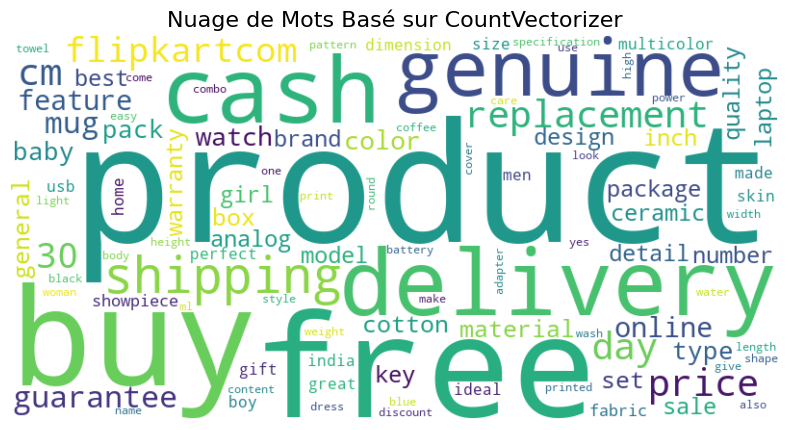

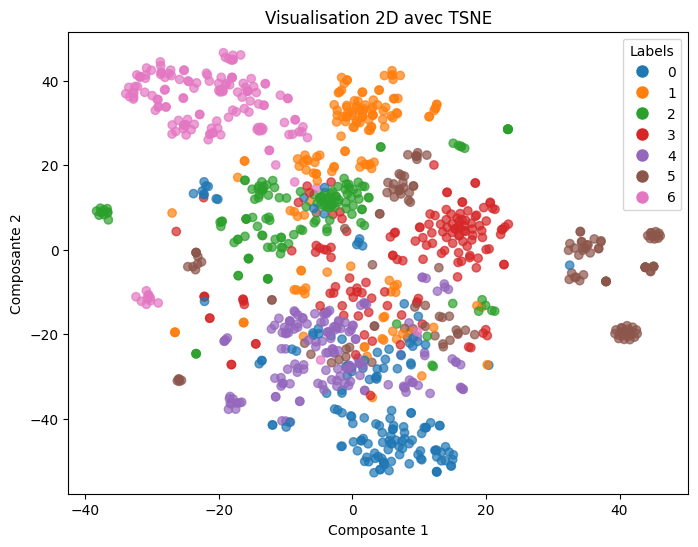

In [ ]:
# Générer les vecteurs TF-IDF
count_vectors = count_vectorizer(df, 'clean_description')

visualize_vectors(count_vectors, numeric_labels, dimensions=2, reduction_method="tsne")
visualize_vectors(count_vectors, numeric_labels, dimensions=3, reduction_method="tsne")

#### <a id='toc3_2_2_2_'></a>[TF/IDF](#toc0_)

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def tfidf(df, column_name, top_n=100):
    """
    Génère un nuage de mots basé sur les scores TF-IDF.
    
    :param df: DataFrame contenant les données.
    :param column_name: Nom de la colonne contenant le texte nettoyé.
    :param top_n: Nombre de mots à inclure dans le nuage de mots.
    :return: Matrice TF-IDF sous forme dense.
    """
    # Initialiser TfidfVectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[column_name])
    
    # Obtenir le vocabulaire et les scores TF-IDF moyens
    vocab = vectorizer.get_feature_names_out()
    avg_scores = tfidf_matrix.mean(axis=0).A1  # Moyenne des scores TF-IDF sur tous les documents
    
    # Créer un dictionnaire mot-score
    word_scores = dict(zip(vocab, avg_scores))
    
    # Sélectionner les mots avec les scores TF-IDF les plus élevés
    sorted_word_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_words_dict = dict(sorted_word_scores)
    
    # Générer le nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Nuage de Mots Basé sur TF-IDF", fontsize=16)
    plt.show()
    
    # Retourner la matrice TF-IDF sous forme dense
    return tfidf_matrix.toarray()

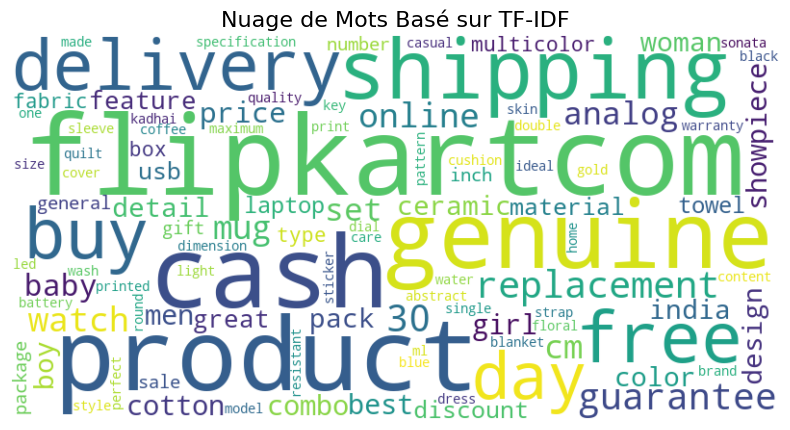

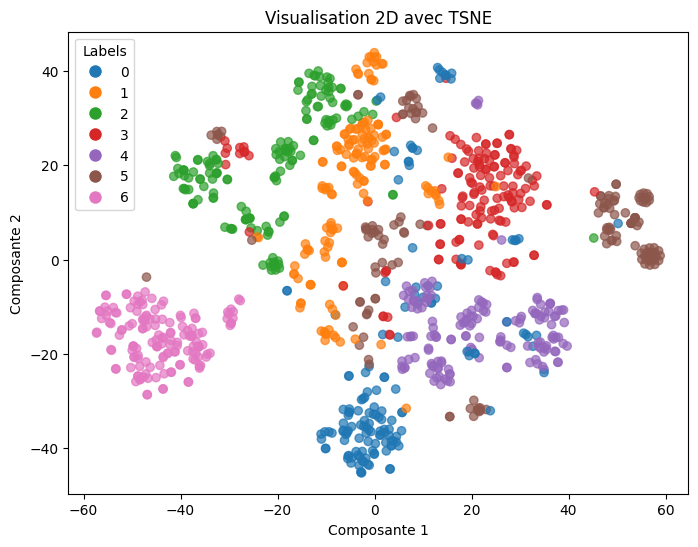

In [ ]:
# Générer les vecteurs TF-IDF
tfidf_vectors = tfidf(df, 'clean_description')

visualize_vectors(tfidf_vectors, numeric_labels, dimensions=2, reduction_method="tsne")
visualize_vectors(tfidf_vectors, numeric_labels, dimensions=3, reduction_method="tsne")

#### <a id='toc3_2_2_3_'></a>[Word2Vec](#toc0_)

In [13]:
# def word2vec_embedding(texts, model=None):
#     if model is None:
#         raise ValueError("Un modèle Word2Vec doit être fourni.")
    
#     def get_sentence_vector(sentence):
#         words = sentence.split()
#         word_vectors = [model.wv[word] for word in words if word in model.wv]
#         return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)
    
#     return np.array([get_sentence_vector(text) for text in texts])



# sentences = [text.split() for text in df["clean_description"]]
# word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# w2v_embeddings = word2vec_embedding(df['clean_description'], model=word2vec_model)

# visualize_vectors(w2v_embeddings, numeric_labels, dimensions=2)
# visualize_vectors(w2v_embeddings, numeric_labels, dimensions=3)

In [ ]:
# def use_embedding(texts):
#     model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
#     return model(texts).numpy()

# use_embedding(df['description'])

#### <a id='toc3_2_2_4_'></a>[Sentence Transformer](#toc0_)

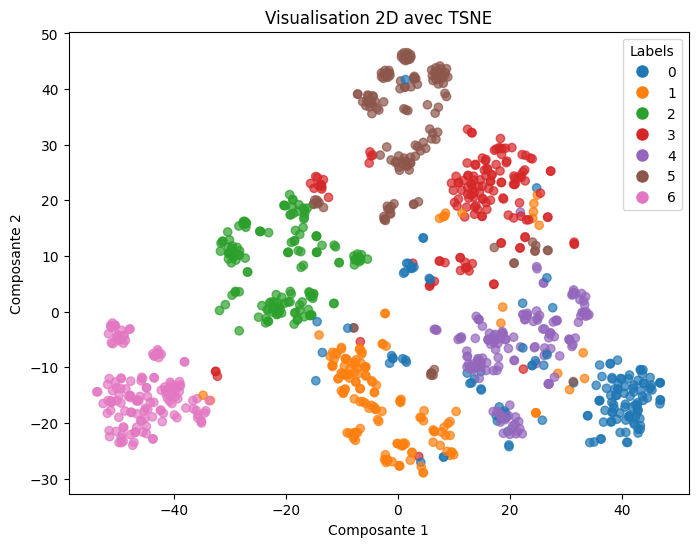

In [16]:
def bert_embedding(texts, model_name="all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    return model.encode(texts)

bert_embedding = bert_embedding(df['description'])
visualize_vectors(bert_embedding, numeric_labels, dimensions=2)
visualize_vectors(bert_embedding, numeric_labels, dimensions=3)

Les embeddings de Sentence Transformer (BERT) sont plus adaptés pour la classification supervisée de descriptions de produits car ils capturent la sémantique des mots en tenant compte de leur contexte, contrairement à CountVectorizer, TF-IDF ou Word2Vec, qui ignorent ou simplifient le contexte. Alors que Universal Sentence Encoder (USE) offre une représentation au niveau phrase, il reste moins précis que BERT, qui utilise un mécanisme d’attention bidirectionnel pour modéliser les relations complexes et les nuances linguistiques. De plus, BERT peut être affiné sur des données spécifiques, renforçant son adaptabilité. Sa capacité à gérer des phrases ambiguës et complexes en fait un choix supérieur pour maximiser la précision.

## <a id='toc3_3_'></a>[Cluster avec Kmeans](#toc0_)

In [ ]:
def ari_score_nlp(df, embeddings):
    model = KMeans(n_clusters=7, n_init=100)
    clusters = model.fit_predict(embeddings)

    df['cluster'] = clusters
    true_labels = df['label']

    ari = adjusted_rand_score(true_labels,clusters)
    print('Score ARI: ', ari)
    return ari

In [ ]:
ari_score_nlp(df, bert_embedding)

Score ARI:  0.6534091313220504


0.6534091313220504

## <a id='toc3_4_'></a>[Conclusion](#toc0_)

IL est tout a fait possible de faire de la classification supervisé avec les données textuel en partant du principe que l'on utilise des embedding contextuelle 